##Load the data and install necessary dependencies

In [ ]:
!pip install librosa

In [ ]:
import zipfile

import numpy as np
import pandas as pd

import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Deep learning libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

# Statistical distributions for randomized search
from scipy.stats import loguniform, randint

# Ensure that plots are displayed in the Jupyter Notebook
%matplotlib inline

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
zip_file_path = '/content/drive/My Drive/sound.zip'

Mounted at /content/drive


In [ ]:
destination_dir = '/content/gtzan_dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print("Dataset extracted to:", destination_dir)

Dataset extracted to: /content/gtzan_dataset


#Process data

In [ ]:
genres_path = '/content/gtzan_dataset/Data/genres_original'

# Iterate through each genre folder and print the number of files
for genre in os.listdir(genres_path):
    genre_folder = os.path.join(genres_path, genre)
    if os.path.isdir(genre_folder):
        print(f"Genre: {genre}, Number of files: {len(os.listdir(genre_folder))}")


Genre: blues, Number of files: 100
Genre: reggae, Number of files: 100
Genre: disco, Number of files: 100
Genre: rock, Number of files: 100
Genre: hiphop, Number of files: 100
Genre: pop, Number of files: 100
Genre: country, Number of files: 100
Genre: classical, Number of files: 100
Genre: jazz, Number of files: 100
Genre: metal, Number of files: 100


In [ ]:
audio_path = '/content/gtzan_dataset/Data/genres_original/jazz/jazz.00053.wav'
audio, sr = librosa.load(audio_path)

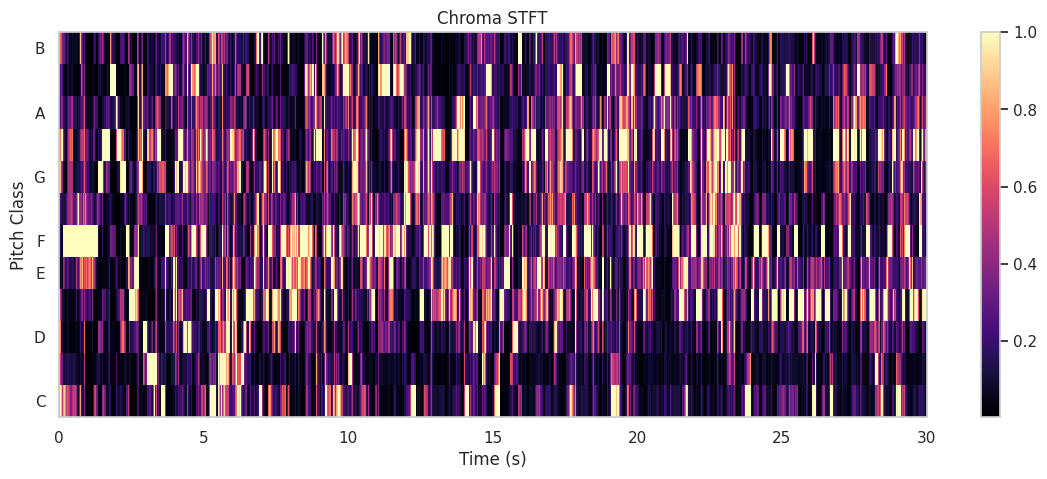

In [ ]:
chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', sr=sr)
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('Pitch Class')
plt.title('Chroma STFT')
plt.show()

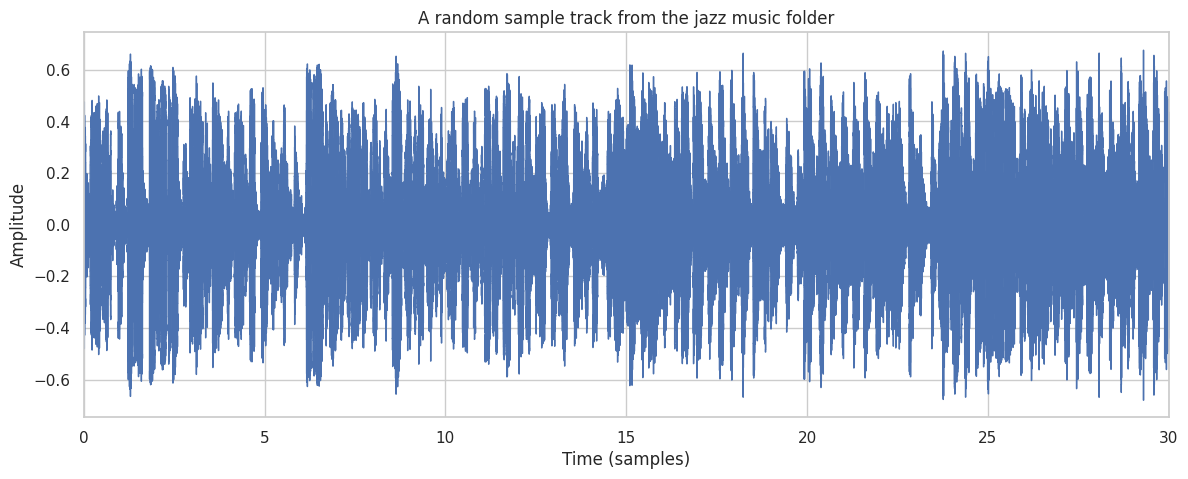

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('A random sample track from the jazz music folder')
plt.xlim([0,30])
plt.show()

Listed below are the audio features that are able to be seen in the CSV provided by the GTZAN Dataset.

1. Chroma STFT (Short-Time Fourier Transform): Measures the intensity of different pitches in a music track, providing a representation of the audio in terms of its harmonic content across 12 different pitch classes.

2. RMS (Root Mean Square) Mean: Indicates the average power or loudness of the audio signal.

3. Spectral Centroid Mean: Represents the "center of mass" of the spectrum, giving a sense of the brightness of a sound.

4. Spectral Bandwidth Mean: Measures the width of the band of light at half the peak maximum and effectively indicates the range of frequencies present in the sound.

5. Rolloff Mean: The frequency below which a specified percentage (typically 85% to 95%) of the total spectral energy lies, highlighting the shape of the audio spectrum.

6. Zero Crossing Rate Mean: The rate at which the signal changes signs, which can indicate the noisiness or the complexity of a sound.

7. Harmony Mean: Extracts the harmonic components of the audio, which are important for the perception of musical notes.

8. Perceptual Sharpness Mean: Measures the sharpness or brightness of the audio, which affects how listeners perceive the "edge" or clarity of a sound.

9. Tempo: The speed at which a piece of music is played, calculated in beats per minute (BPM).

10. MFCC (Mel Frequency Cepstral Coefficients) Mean: Describes the overall shape of the spectral envelope and is widely used in audio signal processing and speech recognition for timbre and speech clarity characterization.

In [ ]:
features_3_sec_path = '/content/gtzan_dataset/Data/features_3_sec.csv'
features_3_sec = pd.read_csv(features_3_sec_path)

features_3_sec.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
features_3_sec = features_3_sec.drop('filename', axis = 1)

In [ ]:
X = features_3_sec.iloc[:,:-1]
y = features_3_sec.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)


In [ ]:
X = features_3_sec.drop(columns=['label','tempo'])
y = features_3_sec['label']

In [ ]:
#LabelEncoder from Scikit-learn is utilized to transform each unique music genre into a specific integer.
labelencoder = LabelEncoder()

y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#Data models

##K-Nearest Neighbors (KNN)

K-Nearest Neighbors (KNN) is a simple, yet effective machine learning algorithm used primarily for classification, though it can also be used for regression. It classifies a new data point based on the majority vote of its 'k' nearest neighbors, with 'k' being a user-defined constant. KNN is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until classification. The simplicity of KNN makes it particularly easy to implement and understand, but it becomes significantly slower as the size of data increases.

In [ ]:
# Define the parameter grid for the random search
param_grid = {
    'n_neighbors': randint(1, 15),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'p': [1, 2]  # Power parameter for the Minkowski distance metric
}

# Create the KNN classifier
knn = KNeighborsClassifier()

# Perform the random search
random_search_knn = RandomizedSearchCV(
    knn, param_distributions=param_grid, n_iter=10, cv=5, random_state=42
)
random_search_knn.fit(X_train, y_train)

# Evaluate the KNN model with the best parameters on the test set
best_knn = random_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
test_accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Evaluate the KNN model on the training set
y_train_pred_knn = best_knn.predict(X_train)
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)

print("Train KNN Accuracy:", train_accuracy_knn)
print("Test KNN Accuracy:", test_accuracy_knn)

Train KNN Accuracy: 0.9992492492492493
Test KNN Accuracy: 0.9324324324324325


##Artificial Neural Networks (ANN)

Artificial Neural Networks (ANN) are a cornerstone of modern machine learning, inspired by the biological processes of the human brain. ANNs consist of layers of interconnected nodes, or "neurons," each capable of performing simple computations. By processing inputs through multiple layers of these neurons, ANNs can model complex patterns and relationships within data. The adaptability and learning capability of ANNs make them particularly powerful for tackling large-scale and complex problems such as music genre classification.

In [ ]:
# Define the model architecture
model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=len(np.unique(y_train)), activation='softmax'))  # Adjusted to use np.unique for flexibility

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Retrieve training and validation accuracy
train_accuracy = history.history['accuracy'][-1]  # Last epoch accuracy
val_accuracy = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

# Predict on test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_labels)

# Print accuracies
print('Training accuracy:', train_accuracy)
print('Validation accuracy:', val_accuracy)
print('Test accuracy:', test_accuracy)


Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.4336 - loss: 1.5810 - val_accuracy: 0.6907 - val_loss: 0.8958
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6949 - loss: 0.8981 - val_accuracy: 0.7367 - val_loss: 0.7346
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7498 - loss: 0.7425 - val_accuracy: 0.8108 - val_loss: 0.5589
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7820 - loss: 0.6238 - val_accuracy: 0.8268 - val_loss: 0.5247
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8158 - loss: 0.5317 - val_accuracy: 0.8333 - val_loss: 0.4769
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8344 - loss: 0.4888 - val_accuracy: 0.8584 - val_loss: 0.4448
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8470 - loss: 0.4496 - val_accuracy: 0.8684 - val_loss: 0.3944
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8721 - loss: 0.3838 - val_acc

##Long Short-term Memory (LSTM)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [ ]:
model = Sequential([
    # Input layer with batch normalization
    BatchNormalization(input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),

    # First Bidirectional LSTM layer
    Bidirectional(LSTM(256, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(128, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.3),

    # Dense layers with increasing regularization
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),

    # Output layer
    Dense(10, activation='softmax')
])

# 2. Advanced Compilation Settings
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

# 3. Training with Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# 4. Model Training
history = model.fit(
    X_train_reshaped,
    y_train_cat,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_reducer],
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.3125 - auc: 0.7438 - loss: 4.6282 - val_accuracy: 0.3177 - val_auc: 0.7914 - val_loss: 3.8338 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5532 - auc: 0.8963 - loss: 3.1250 - val_accuracy: 0.6660 - val_auc: 0.9512 - val_loss: 2.3872 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6240 - auc: 0.9259 - loss: 2.3639 - val_accuracy: 0.7286 - val_auc: 0.9667 - val_loss: 1.7051 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.6676 - auc: 0.9422 - loss: 1.8382 - val_accuracy: 0.7686 - val_auc: 0.9727 - val_loss: 1.3355 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6957 - auc: 0.9518 - loss: 1.4903 - val_accuracy: 0.7692 - val_auc: 0.9726 - val_loss: 1.1550 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional, Input
from tensorflow.keras.layers import Multiply, Permute, Reshape, Activation, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

# Define input shape
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])

# Model with Attention
inputs = Input(shape=input_shape)

# Initial normalization
x = BatchNormalization()(inputs)

# First Bidirectional LSTM with Attention
lstm1 = Bidirectional(LSTM(256, return_sequences=True))(x)
# Attention mechanism for first layer
attention1 = Dense(1, use_bias=True)(lstm1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax')(attention1)
attention1 = Reshape((1, attention1.shape[1]))(attention1)
attention_output1 = Multiply()([lstm1, attention1])
norm1 = BatchNormalization()(attention_output1)
drop1 = Dropout(0.3)(norm1)

# Second Bidirectional LSTM with Attention
lstm2 = Bidirectional(LSTM(128, return_sequences=True))(drop1)
# Attention mechanism for second layer
attention2 = Dense(1, use_bias=True)(lstm2)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax')(attention2)
attention2 = Reshape((1, attention2.shape[1]))(attention2)
attention_output2 = Multiply()([lstm2, attention2])
norm2 = BatchNormalization()(attention_output2)
drop2 = Dropout(0.3)(norm2)

# Third Bidirectional LSTM
lstm3 = Bidirectional(LSTM(64, return_sequences=False))(drop2)
norm3 = BatchNormalization()(lstm3)
drop3 = Dropout(0.3)(norm3)

# Dense layers with regularization
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(drop3)
norm4 = BatchNormalization()(dense1)
drop4 = Dropout(0.4)(norm4)

dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(drop4)
norm5 = BatchNormalization()(dense2)
drop5 = Dropout(0.4)(norm5)

# Output layer
outputs = Dense(10, activation='softmax')(drop5)

# Create model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Model summary
model.summary()

# Compile model
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Model Training
history = model.fit(
    X_train_reshaped,
    y_train_cat,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, lr_reducer],
    verbose=1
)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 1, 58)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 1, 58)          │            232 │ input_layer_5[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_8           │ (None, 1, 512)         │        645,120 │ batch_normalization_1… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 1, 1)           │            513 │ bidirectional_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 1)              │              0 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 1)              │              0 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 1, 1)           │              0 │ activation_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_4 (Multiply)     │ (None, 1, 512)         │              0 │ bidirectional_8[0][0], │
│                           │                        │                │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 1, 512)         │          2,048 │ multiply_4[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 1, 512)         │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_9           │ (None, 1, 256)         │        656,384 │ dropout_22[0][0]       │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 1, 1)           │            257 │ bidirectional_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 1)              │              0 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 1)              │              0 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 1, 1)           │              0 │ activation_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_5 (Multiply)     │ (None, 1, 256)         │              0 │ bidirectional_9[0][0], │
│                           │                        │                │ reshape_5[0][0]        │
├──────────────────────

 Total params: 1,496,628 (5.71 MB)

 Trainable params: 1,494,336 (5.70 MB)

 Non-trainable params: 2,292 (8.95 KB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.2397 - auc: 0.6819 - loss: 4.5054 - val_accuracy: 0.2245 - val_auc: 0.7717 - val_loss: 3.6822 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.4433 - auc: 0.8523 - loss: 3.2067 - val_accuracy: 0.6323 - val_auc: 0.9390 - val_loss: 2.3855 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5486 - auc: 0.9004 - loss: 2.5002 - val_accuracy: 0.6967 - val_auc: 0.9548 - val_loss: 1.8151 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6076 - auc: 0.9219 - loss: 2.0115 - val_accuracy: 0.7336 - val_auc: 0.9674 - val_loss: 1.4156 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6670 - auc: 0.9376 - loss: 1.6279 - val_accuracy: 0.7498 - val_auc: 0.9672 - val_loss: 1.2164 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6772 - auc: 

#Evaluate accuracy

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


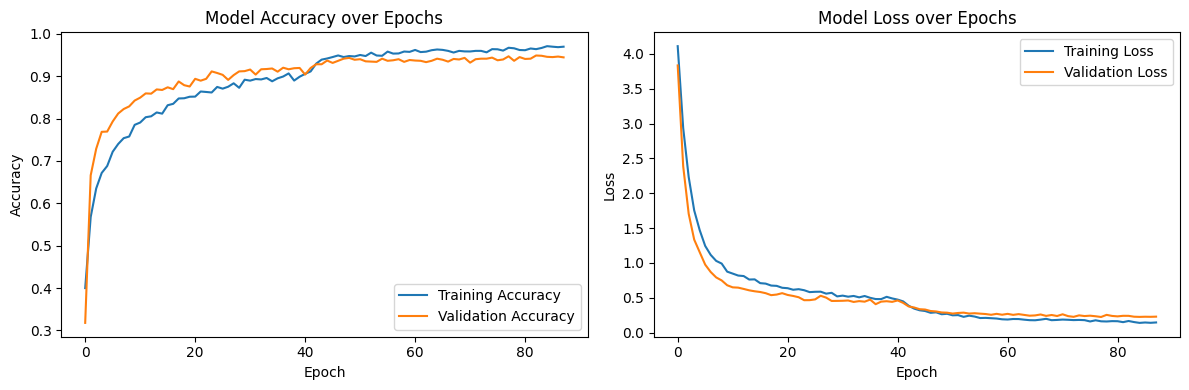


Classification Report:
              precision    recall  f1-score   support

       blues       0.94      0.94      0.94       208
   classical       0.93      0.97      0.95       203
     country       0.90      0.93      0.91       186
       disco       0.93      0.93      0.93       199
      hiphop       0.98      0.92      0.95       218
        jazz       0.93      0.94      0.94       192
       metal       0.95      0.97      0.96       204
         pop       0.96      0.96      0.96       180
      reggae       0.96      0.94      0.95       211
        rock       0.94      0.91      0.93       197

    accuracy                           0.94      1998
   macro avg       0.94      0.94      0.94      1998
weighted avg       0.94      0.94      0.94      1998


Detailed Metrics:
Accuracy: 0.9424
Precision: 0.9429
Recall: 0.9424
F1 Score: 0.9425


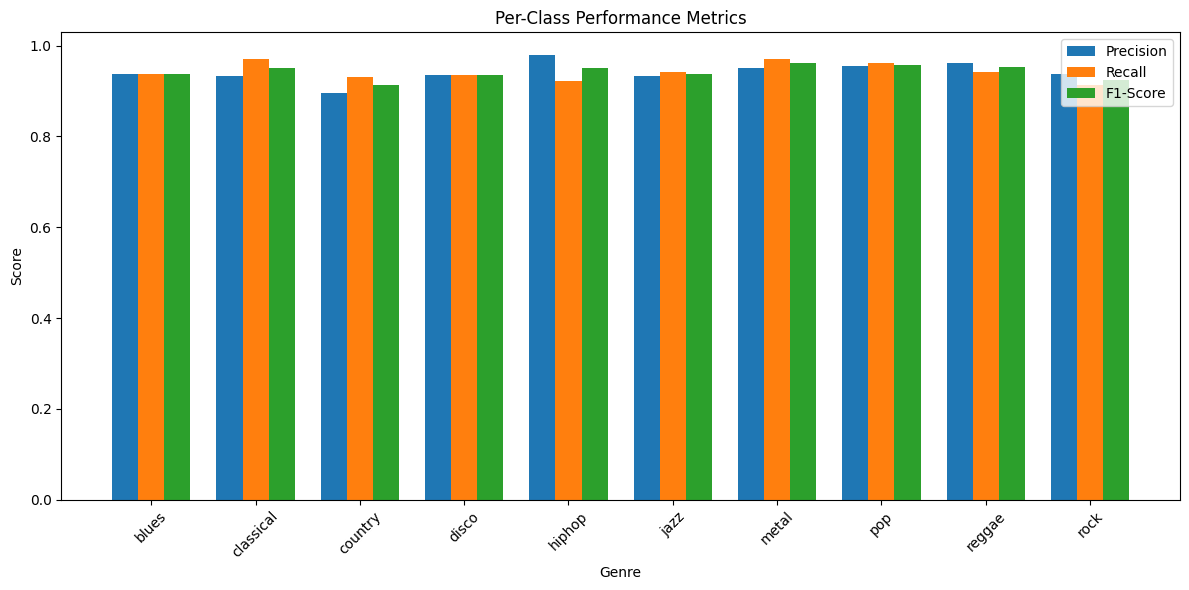

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Get predictions
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# 1. Plot Training History
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 3. Print Classification Report
class_names = labelencoder.classes_  # Get original class names
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

# 4. Calculate and display various metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_classes, y_pred_classes, average='weighted')

print("\nDetailed Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 6. Plot Per-Class Performance
plt.figure(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

precision_per_class = precision_recall_fscore_support(y_test_classes, y_pred_classes)[0]
recall_per_class = precision_recall_fscore_support(y_test_classes, y_pred_classes)[1]
f1_per_class = precision_recall_fscore_support(y_test_classes, y_pred_classes)[2]

plt.bar(x - width, precision_per_class, width, label='Precision')
plt.bar(x, recall_per_class, width, label='Recall')
plt.bar(x + width, f1_per_class, width, label='F1-Score')

plt.xlabel('Genre')
plt.ylabel('Score')
plt.title('Per-Class Performance Metrics')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
predictions = model.predict(X_test_reshaped)

predicted_labels = predictions.argmax(axis=1)
true_labels = y_test_encoded

#for i in range(10):  # Display the first 10 predictions
#    print(f"True label: {true_labels[i]}, Predicted label: {predicted_labels[i]}")

# Get the original genre names using label_encoder.inverse_transform()
predicted_genre_names = label_encoder.inverse_transform(predicted_labels)
true_genre_names = label_encoder.inverse_transform(true_labels)

for i in range(10):  # Display the first 10 predictions
    print(f"True genre: {true_genre_names[i]}, Predicted genre: {predicted_genre_names[i]}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
True genre: 4, Predicted genre: 4
True genre: 5, Predicted genre: 5
True genre: 0, Predicted genre: 0
True genre: 0, Predicted genre: 0
True genre: 6, Predicted genre: 6
True genre: 9, Predicted genre: 9
True genre: 7, Predicted genre: 7
True genre: 2, Predicted genre: 2
True genre: 2, Predicted genre: 2
True genre: 0, Predicted genre: 0


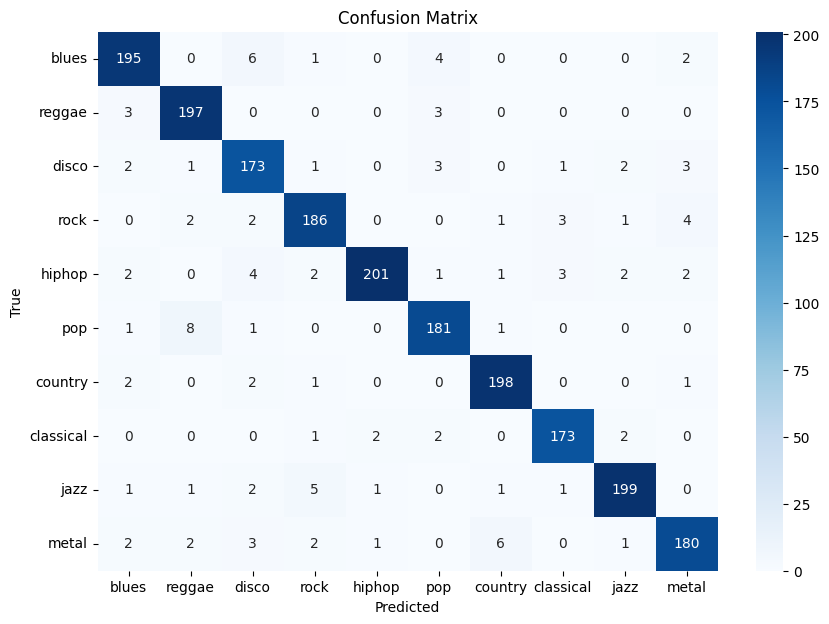

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

genres_path = '/content/gtzan_dataset/Data/genres_original'

genres = os.listdir(genres_path)

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
predictions = model.predict(X_test_reshaped)

predicted_labels = predictions.argmax(axis=1)
true_labels = y_test_encoded


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
